This is an example usage of a convolutional neural network constructed solely with components of this machine learning library project.
 
A neural network with plain batch gradient descent will be used to tackle the classic MNIST number classification problem. With this approach, a classification accuracy of 98.1% was achieved on the test set.

In [ ]:
# Importing features of this machine learning library
from nn.BaseModel import BaseModel
from nn.layers import Linear, Conv2D, MaxPool2D, Dropout
from nn.activations import ReLu
from nn.loss_functions import CategoricalCrossEntropyLoss
from nn.optimizers import GDOptimizer
from utils.preprocessing import train_val_test_split

# Importin other libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import copy  # To save the best model state

Defining the convolutional neural network.

In [90]:
class CNN(BaseModel):
    def __init__(self):
        super().__init__()

        # Defining the layers of the model
        self.conv1 = Conv2D(1, 16, 3, 1)
        self.relu1 = ReLu()
        self.pool1 = MaxPool2D(2, 2)

        self.conv2 = Conv2D(16, 32, 3, 1)
        self.relu2 = ReLu()
        self.pool2 = MaxPool2D(2, 2)

        self.fc1 = Linear(32 * 5 * 5, 128)
        self.relu3 = ReLu()
        self.dropout = Dropout(p=0.5)
        self.fc2 = Linear(128, 10)

        self.add_layer(self.conv1)
        self.add_layer(self.conv2)
        self.add_layer(self.fc1)
        self.add_layer(self.fc2)

    def forward(self, x):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)

        x = x.reshape(x.shape[0], -1)

        x = self.fc1.forward(x)
        x = self.relu3.forward(x)
        x = self.dropout.forward(x)
        x = self.fc2.forward(x)

        return x

    def backward(self, dy):
        dy = self.fc2.backward(dy)
        dy = self.dropout.backward(dy)
        dy = self.relu3.backward(dy)
        dy = self.fc1.backward(dy)

        dy = dy.reshape(-1, 32, 5, 5)

        dy = self.pool2.backward(dy)
        dy = self.relu2.backward(dy)
        dy = self.conv2.backward(dy)

        dy = self.pool1.backward(dy)
        dy = self.relu1.backward(dy)
        dy = self.conv1.backward(dy)

        return dy

Downloading the MNIST numbers dataset.

In [91]:
# Download the data
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Normalize the images (28x28) to [0, 1]
X = X / 255

# Convert the labels to integers
y = y.astype(int)

# Convert the data into numpy arrays
X = np.array(X)
y = np.array(y)

In [92]:
# Convert y to target classes
y_new = np.zeros((y.shape[0], 10))
for i, target in enumerate(y):
    y_new[i, target] = 1
y = y_new

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


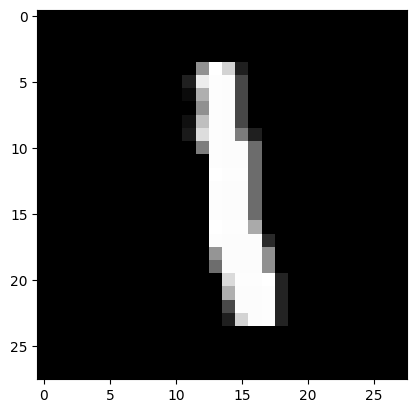

In [93]:
# Sanity check
image = 6
x_sample = X[image].reshape(28, 28)
y_sample = y[image]

print(y_sample)
plt.imshow(x_sample, 'gray')

In [ ]:
# Split the data into training and testing sets
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(X, y, val_size=0.15 ,test_size=0.15)

In [95]:
# Reshape the data for CNN input
x_train = x_train.reshape(-1, 1, 28, 28)
y_train = y_train.reshape(-1, 10)

x_val = x_val.reshape(-1, 1, 28, 28)
y_val = y_val.reshape(-1, 10)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(49000, 1, 28, 28) (49000, 10)
(10500, 1, 28, 28) (10500, 10)


In [96]:
# Take 30 percent of the training data due to computational constraints
x_train_reduced = x_train[:int(0.3 * x_train.shape[0])]
y_train_reduced = y_train[:int(0.3 * y_train.shape[0])]

x_val_reduced = x_val[:int(0.3 * x_val.shape[0])]
y_val_reduced = y_val[:int(0.3 * y_val.shape[0])]

print(x_train_reduced.shape, y_train_reduced.shape)
print(x_val_reduced.shape, y_val_reduced.shape)

(14700, 1, 28, 28) (14700, 10)
(3150, 1, 28, 28) (3150, 10)


Training the neural network.

In [ ]:
learning_rate = 0.01
batch_size = 64
epochs = 100

# Early stop parameters
patience = 5 
patience_counter = 0
best_val_loss = np.inf
best_model_state = None

# Initiate the model, loss and optimizer
model = CNN()
loss_fn = CategoricalCrossEntropyLoss()
optimizer = GDOptimizer(model, learning_rate)

# Data preparation
num_train_batches = x_train_reduced.shape[0] // batch_size
num_val_batches = x_val_reduced.shape[0] // batch_size

# Training
train_loss_history = []
val_loss_history = []
print("Starting training...")

for epoch in range(epochs):
    model.dropout.is_training = True
    train_epoch_loss = []
    
    # Shuffle training data each epoch
    permutation = np.random.permutation(x_train_reduced.shape[0])
    x_train_shuffled = x_train_reduced[permutation]
    y_train_shuffled = y_train_reduced[permutation]

    for i in range(num_train_batches):
        x_batch = x_train_shuffled[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_shuffled[i*batch_size:(i+1)*batch_size]

        # Forward pass
        logits = model.forward(x_batch)
        loss = loss_fn.forward(logits, y_batch)

        train_epoch_loss.append(loss)

        # Backward pass
        dy = loss_fn.backward()
        model.backward(dy)

        # Update weights
        optimizer.update()

    average_train_loss = np.mean(train_epoch_loss)
    train_loss_history.append(np.mean(train_epoch_loss))

    # Validation phase
    model.dropout.is_training = False # Switch to evaluation mode
    val_epoch_loss = []
    
    for i in range(num_val_batches):
        start = i * batch_size
        end = start + batch_size
        x_val_batch = x_val_reduced[i*batch_size:(i+1)*batch_size]
        y_val_batch = y_val_reduced[i*batch_size:(i+1)*batch_size]

        # Forward pass only
        logits = model.forward(x_val_batch)
        loss = loss_fn.forward(logits, y_val_batch)
        val_epoch_loss.append(loss)

    average_val_loss = np.mean(val_epoch_loss)
    val_loss_history.append(average_val_loss)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}')

    # Early stop check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model)
    else:
        patience_counter += 1
        print(f'  -> Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print("\nEarly stop")
        break
    
# Load the best performing model state
if best_model_state is not None:
    print("\nLoading model state from epoch with lowest validation loss.")
    model = best_model_state

model.dropout.is_training = False
print("Training finished.")

Starting training...
Epoch 1/100 - Train Loss: 1.1984 | Val Loss: 0.4859
Epoch 2/100 - Train Loss: 0.6012 | Val Loss: 0.3367
Epoch 3/100 - Train Loss: 0.4766 | Val Loss: 0.2890
Epoch 4/100 - Train Loss: 0.3989 | Val Loss: 0.2475
Epoch 5/100 - Train Loss: 0.3578 | Val Loss: 0.2257
Epoch 6/100 - Train Loss: 0.3258 | Val Loss: 0.2136
Epoch 7/100 - Train Loss: 0.2994 | Val Loss: 0.1934
Epoch 8/100 - Train Loss: 0.2710 | Val Loss: 0.1817
Epoch 9/100 - Train Loss: 0.2501 | Val Loss: 0.1671
Epoch 10/100 - Train Loss: 0.2345 | Val Loss: 0.1440
Epoch 11/100 - Train Loss: 0.2210 | Val Loss: 0.1410
Epoch 12/100 - Train Loss: 0.2083 | Val Loss: 0.1311
Epoch 13/100 - Train Loss: 0.2002 | Val Loss: 0.1235
Epoch 14/100 - Train Loss: 0.1848 | Val Loss: 0.1167
Epoch 15/100 - Train Loss: 0.1830 | Val Loss: 0.1128
Epoch 16/100 - Train Loss: 0.1745 | Val Loss: 0.1119
Epoch 17/100 - Train Loss: 0.1637 | Val Loss: 0.1082
Epoch 18/100 - Train Loss: 0.1550 | Val Loss: 0.1053
Epoch 19/100 - Train Loss: 0.1458 

Evaluating the model.

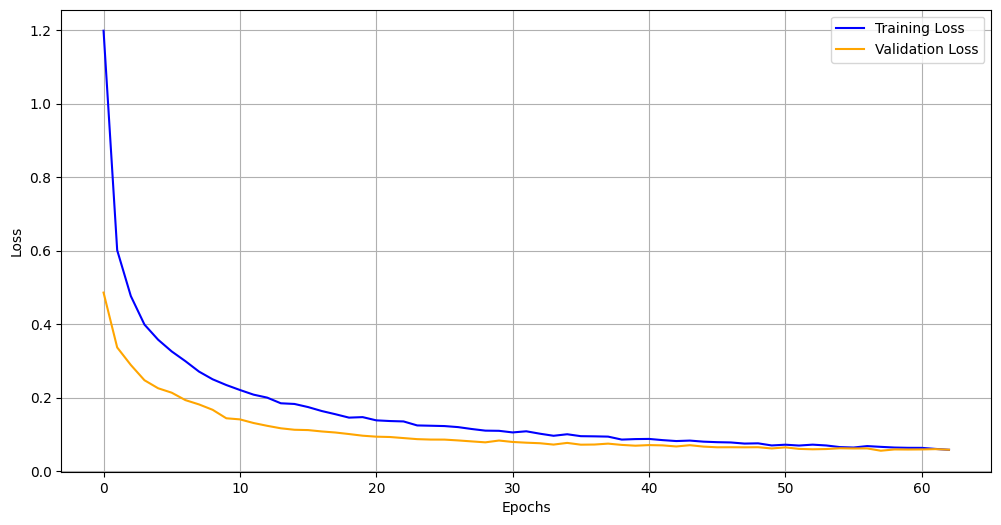

In [98]:
# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
x_test = x_test.reshape(-1, 1, 28, 28)
y_test = y_test.reshape(-1, 10)
print(x_test.shape, y_test.shape)

(10500, 1, 28, 28) (10500, 10)


In [100]:
# Accuracy on the test set
y_pred = model.forward(x_test)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print(f'Accuracy on the test set: {accuracy}')

Accuracy on the test set: 0.9813333333333333


In [101]:
# Accuracy on the train set
y_pred_train = model.forward(x_train_reduced)
accuracy_train = np.mean(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_reduced, axis=1))
print(f'Accuracy on the train set: {accuracy_train}')


Accuracy on the train set: 0.9938775510204082


The neural network achieved an accuracy of 98.1% on the test set of the MNIST dataset.

Using the model.

In [ ]:
# A helper function to convert logits to probabilities for visualization
def softmax(z):
    exps = np.exp(z - np.max(z)) # for numerical stability
    return exps / np.sum(exps)

--- Prediction for sample index: 30 ---
Model Logits:     [-9.670 -1.962 -4.730 -3.106 18.406 -0.456 -2.825 3.672 -0.882 8.907]
Probabilities:    [0.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 0.000]

-------------------------------------------
True Label:       4
Predicted Label:  4
-------------------------------------------


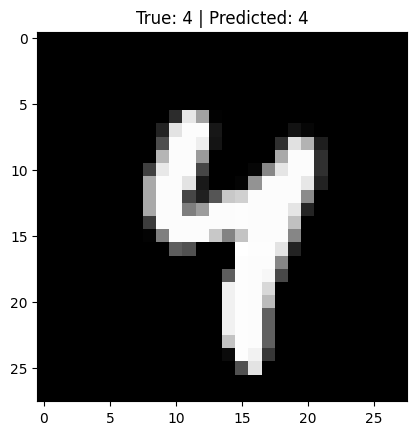

In [ ]:
image_index = 30
x_sample = x_test[image_index]
y_sample = y_test[image_index]

x_sample_batch = x_sample.reshape(1, 1, 28, 28)

# Models predictions, logits
model.dropout.is_training = False
logits = model.forward(x_sample_batch)

# Convert logits to probabilities using softmax
probabilities = softmax(logits)

predicted_label = np.argmax(logits) 
true_label = np.argmax(y_sample) # Convert one-hot vector to integer

print(f"--- Prediction for sample index: {image_index} ---")

# Print the raw logits from the model
formatted_logits = np.array2string(logits[0], formatter={'float_kind': lambda x: f"{x:.3f}"})
print(f"Model Logits:     {formatted_logits}")

# Print the probabilities
formatted_probs = np.array2string(probabilities[0], formatter={'float_kind': lambda x: f"{x:.3f}"})
print(f"Probabilities:    {formatted_probs}")

print("\n-------------------------------------------")
print(f'True Label:       {true_label}')
print(f'Predicted Label:  {predicted_label}')
print("-------------------------------------------")

# Display the image
plt.imshow(x_sample.reshape(28, 28), cmap='gray')
plt.title(f"True: {true_label} | Predicted: {predicted_label}")
plt.show()